In HaplotypeCoverage, I saw some weird pattern with some male H1 assemblies having more bases of the genome being uncovered. To explore this a little bit, I decided to look at chrY coverage across the assemblies.

My hypothesis is that some of these uncovered regions from males' H1 are large chrY DELs. 

If this is the case, we might be able to pull out alignments from those regions, see if they're split, and use that to build a 'large DEL' caller to complement paftools.jl (which I'm pretty sure doesn't handle variant calling from split alignments.

First, I had to consolidate all the chrY 1x covered bed files and recalculate genomecov

```bash
grep "chrY" *H1/cov.bed | awk '$4 == 1' | \
    | cut -f2- -d: \
    | bedtools genomecov -g reference.genome.bed  -i - -bga \
    | grep chrY > h1_chrY_1xcov.bed ;

# Also, I want the chrY gap

zgrep chrY HumanGRCh38.mapping.gap.bed.gz > ygap.bed
```

Note that I only used project==hprc cov beds.

I placed these two files in `/variants/data/misc/`

Now, let's plot.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

chrYLength = 57227415
cov = np.zeros(chrYLength)

h1_1x_bed = pd.read_csv("../data/misc/h1_chrY_1xcov.bed", sep='\t', names=["chrom", "start", "end", "count"])
for idx, row in h1_1x_bed.iterrows():
    cov[row['start']:row['end']] = row['count']
    
chrY_gaps = pd.read_csv("../data/misc/ygap.bed", sep='\t', names=["chrom", "start", "end"])

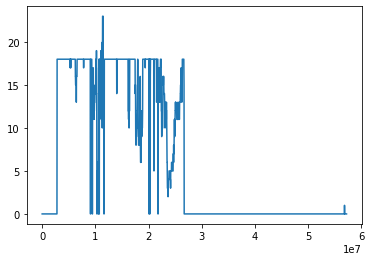

In [3]:
period = 10000 # Plot every period bases
pos = np.arange(len(cov))
plt.plot(pos[::period], cov[::period])

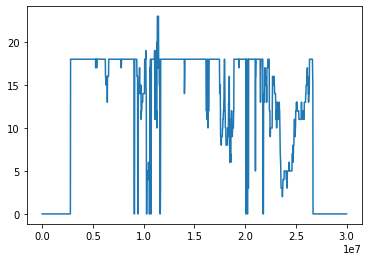

In [4]:
# Zoom in
sub = cov[0:int(3e7)]
p_sub = pos[0:int(3e7)]
plt.plot(p_sub[::period], sub[::period])

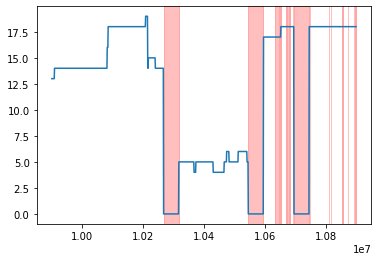

In [5]:
# Zoom in around 1e7

query_position = int(1.04e7)
buffer = 500000
plot_window = slice(query_position - buffer, query_position + buffer)
sub = cov[plot_window]
p_sub = pos[plot_window]
period = 1000
p = plt.plot(p_sub[::period], sub[::period])
# Color in gaps
alpha = 0.25
for i, row in chrY_gaps.iterrows():
    if row['start'] >= plot_window.start and row['end'] <= plot_window.stop:
        plt.axvspan(row['start'], row["end"], color='red', alpha=alpha)
    elif row['start'] < plot_window.start and row['end'] >= plot_window.start:
        plt.axvspan(plot_window.start, row["end"], color='red', alpha=alpha)
    elif row['start'] < plot_window.stop and row['end'] >= plot_window.stop:
        plt.axvspan(plot_window.start, row["end"], color='red', alpha=alpha)

So this region between ~1.02e7 and 1.06e7 could be interesting. Lets get the exact boundaries from the gap

In [6]:
chrY_gaps[chrY_gaps["start"].between(1.02e7, 1.06e7)]

,chrom,start,end
11,chrY,10266944,10316944
12,chrY,10544039,10594039


Should investigate chrY:10,316,944-10,544,039

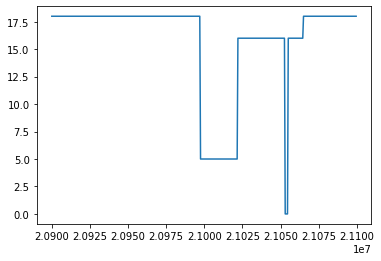

In [7]:
# Zoom in around 2.3e7

query_position = int(2.1e7)
buffer = 100000
plot_window = slice(query_position - buffer, query_position + buffer)
sub = cov[plot_window]
p_sub = pos[plot_window]
period = 500
p = plt.plot(p_sub[::period], sub[::period])
# Color in gaps
alpha = 0.25
for i, row in chrY_gaps.iterrows():
    if row['start'] >= plot_window.start and row['end'] <= plot_window.stop:
        plt.axvspan(row['start'], row["end"], color='red', alpha=alpha)
    elif row['start'] < plot_window.start and row['end'] >= plot_window.start:
        plt.axvspan(plot_window.start, row["end"], color='red', alpha=alpha)
    elif row['start'] < plot_window.stop and row['end'] >= plot_window.stop:
        plt.axvspan(plot_window.start, row["end"], color='red', alpha=alpha)

In [8]:
# Unsophisticated signal processing
from itertools import groupby
signal = cov[plot_window] < 10
grouped_L = [(k, len([_ for _ in g])) for k,g in groupby(signal)]

In [9]:
s_pos = plot_window.start
parts = []
for k, g in grouped_L:
    parts.append([k, s_pos, s_pos + g, cov[s_pos: s_pos+g].mean()])
    s_pos += g
parts = pd.DataFrame(parts, columns=["<10 1x", "start", "end", "mu_cov"])
parts[parts["<10 1x"]]

,<10 1x,start,end,mu_cov
1,True,20997267,21021542,5.000082
3,True,21052873,21054658,0.006723


And here's two more regions that might be worth exploring.